The model takes physical parameters as input and predicts the meshed field representing the solidification morphology. We used a fully connected physics-informed neural network (PINN) because the focus is on learning the mapping from parameters to morphology while enforcing spatial physical constraints. The network consists of three fully connected layers with Tanh activations, which provide smooth nonlinear transformations suitable for approximating diffusion-governed fields. The output layer produces a flattened 250×250 field without activation, allowing the network to learn unconstrained continuous values. A physics-based regularization term is added to the loss function by penalizing the Laplacian of the predicted field, encouraging smoothness and physical realism in the output morphology.

Why only the Laplacian? 
We are predicting the final frame "at equilibrium" so the derivatives with respect to time are 0.
Also, we have no means to compute the source term.

In [ ]:
# Cell 0 

# Basic libraries
import numpy as np
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Device setting (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Cell 1

# Load data
X_train = np.load('X_train.npy')  
Y_train = np.load('Y_train.npy')  
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

print(f"Train Inputs: {X_train.shape}")
print(f"Train Outputs: {Y_train.shape}")
print(f"Test Inputs: {X_test.shape}")
print(f"Test Outputs: {Y_test.shape}")


Train Inputs: (200, 5)
Train Outputs: (200, 250, 250)
Test Inputs: (51, 5)
Test Outputs: (51, 250, 250)


In [2]:
# Cell 2

# Flatten Y from (250, 250) → (62500,)
Y_train_flat = Y_train.reshape(Y_train.shape[0], -1)
Y_test_flat = Y_test.reshape(Y_test.shape[0], -1)

print(f"Train Outputs Flattened: {Y_train_flat.shape}")
print(f"Test Outputs Flattened: {Y_test_flat.shape}")


Train Outputs Flattened: (200, 62500)
Test Outputs Flattened: (51, 62500)


In [ ]:
# Cell 3
# Network architecture

class PINN(nn.Module):
    def __init__(self, input_dim=5, output_dim=62500):  
        super(PINN, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)


In [ ]:
# Cell 4

def physics_loss(predictions):
    """
    Penalize large Laplacians (smoothness + physics-inspired regularization).
    Works for general (batch_size, height*width) flattened predictions.
    """
    batch_size = predictions.shape[0]
    num_pixels = predictions.shape[1]
    grid_size = int(np.sqrt(num_pixels))  # Automatically detect 250 if 62500

    predictions = predictions.view(batch_size, grid_size, grid_size)

    laplacian = (
        -4 * predictions
        + torch.roll(predictions, shifts=1, dims=1)
        + torch.roll(predictions, shifts=-1, dims=1)
        + torch.roll(predictions, shifts=1, dims=2)
        + torch.roll(predictions, shifts=-1, dims=2)
    )
    laplacian = laplacian.view(batch_size, -1)
    loss = torch.mean(laplacian**2)
    return loss


In [ ]:
# Cell 5

# Convert data to torch tensors and move to device (CPU or GPU)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_train_tensor = torch.tensor(Y_train_flat, dtype=torch.float32, device=device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
Y_test_tensor = torch.tensor(Y_test_flat, dtype=torch.float32, device=device)

# Define loss function (MSE) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Weight for physics-informed loss
physics_weight = 0.01  # Tune this if needed


In [ ]:
# Cell 6
# Training

num_epochs = 5000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    preds = model(X_train_tensor)
    data_loss = criterion(preds, Y_train_tensor)
    phys_loss = physics_loss(preds)
    
    total_loss = data_loss + physics_weight * phys_loss
    total_loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        test_loss = criterion(test_preds, Y_test_tensor)
    
    # Logging losses
    train_losses.append(data_loss.item())  # only pure data loss is logged
    test_losses.append(test_loss.item())
    
    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train MSE: {data_loss.item():.6f} | "
              f"Test MSE: {test_loss.item():.6f} | "
              f"Physics Loss: {phys_loss.item():.6f}")


Epoch 1/5000 | Train MSE: 0.242328 | Test MSE: 0.212141 | Physics Loss: 1.161796
Epoch 50/5000 | Train MSE: 0.102689 | Test MSE: 0.103664 | Physics Loss: 0.019041
Epoch 100/5000 | Train MSE: 0.077997 | Test MSE: 0.077485 | Physics Loss: 0.019789
Epoch 150/5000 | Train MSE: 0.059218 | Test MSE: 0.059188 | Physics Loss: 0.009252
Epoch 200/5000 | Train MSE: 0.056691 | Test MSE: 0.057312 | Physics Loss: 0.005385
Epoch 250/5000 | Train MSE: 0.055068 | Test MSE: 0.056514 | Physics Loss: 0.003736
Epoch 300/5000 | Train MSE: 0.053593 | Test MSE: 0.055857 | Physics Loss: 0.003155
Epoch 350/5000 | Train MSE: 0.051739 | Test MSE: 0.054692 | Physics Loss: 0.003237
Epoch 400/5000 | Train MSE: 0.049547 | Test MSE: 0.053108 | Physics Loss: 0.003385
Epoch 450/5000 | Train MSE: 0.046079 | Test MSE: 0.049899 | Physics Loss: 0.003877
Epoch 500/5000 | Train MSE: 0.041120 | Test MSE: 0.045725 | Physics Loss: 0.005048
Epoch 550/5000 | Train MSE: 0.036435 | Test MSE: 0.041819 | Physics Loss: 0.006023
Epoch 6

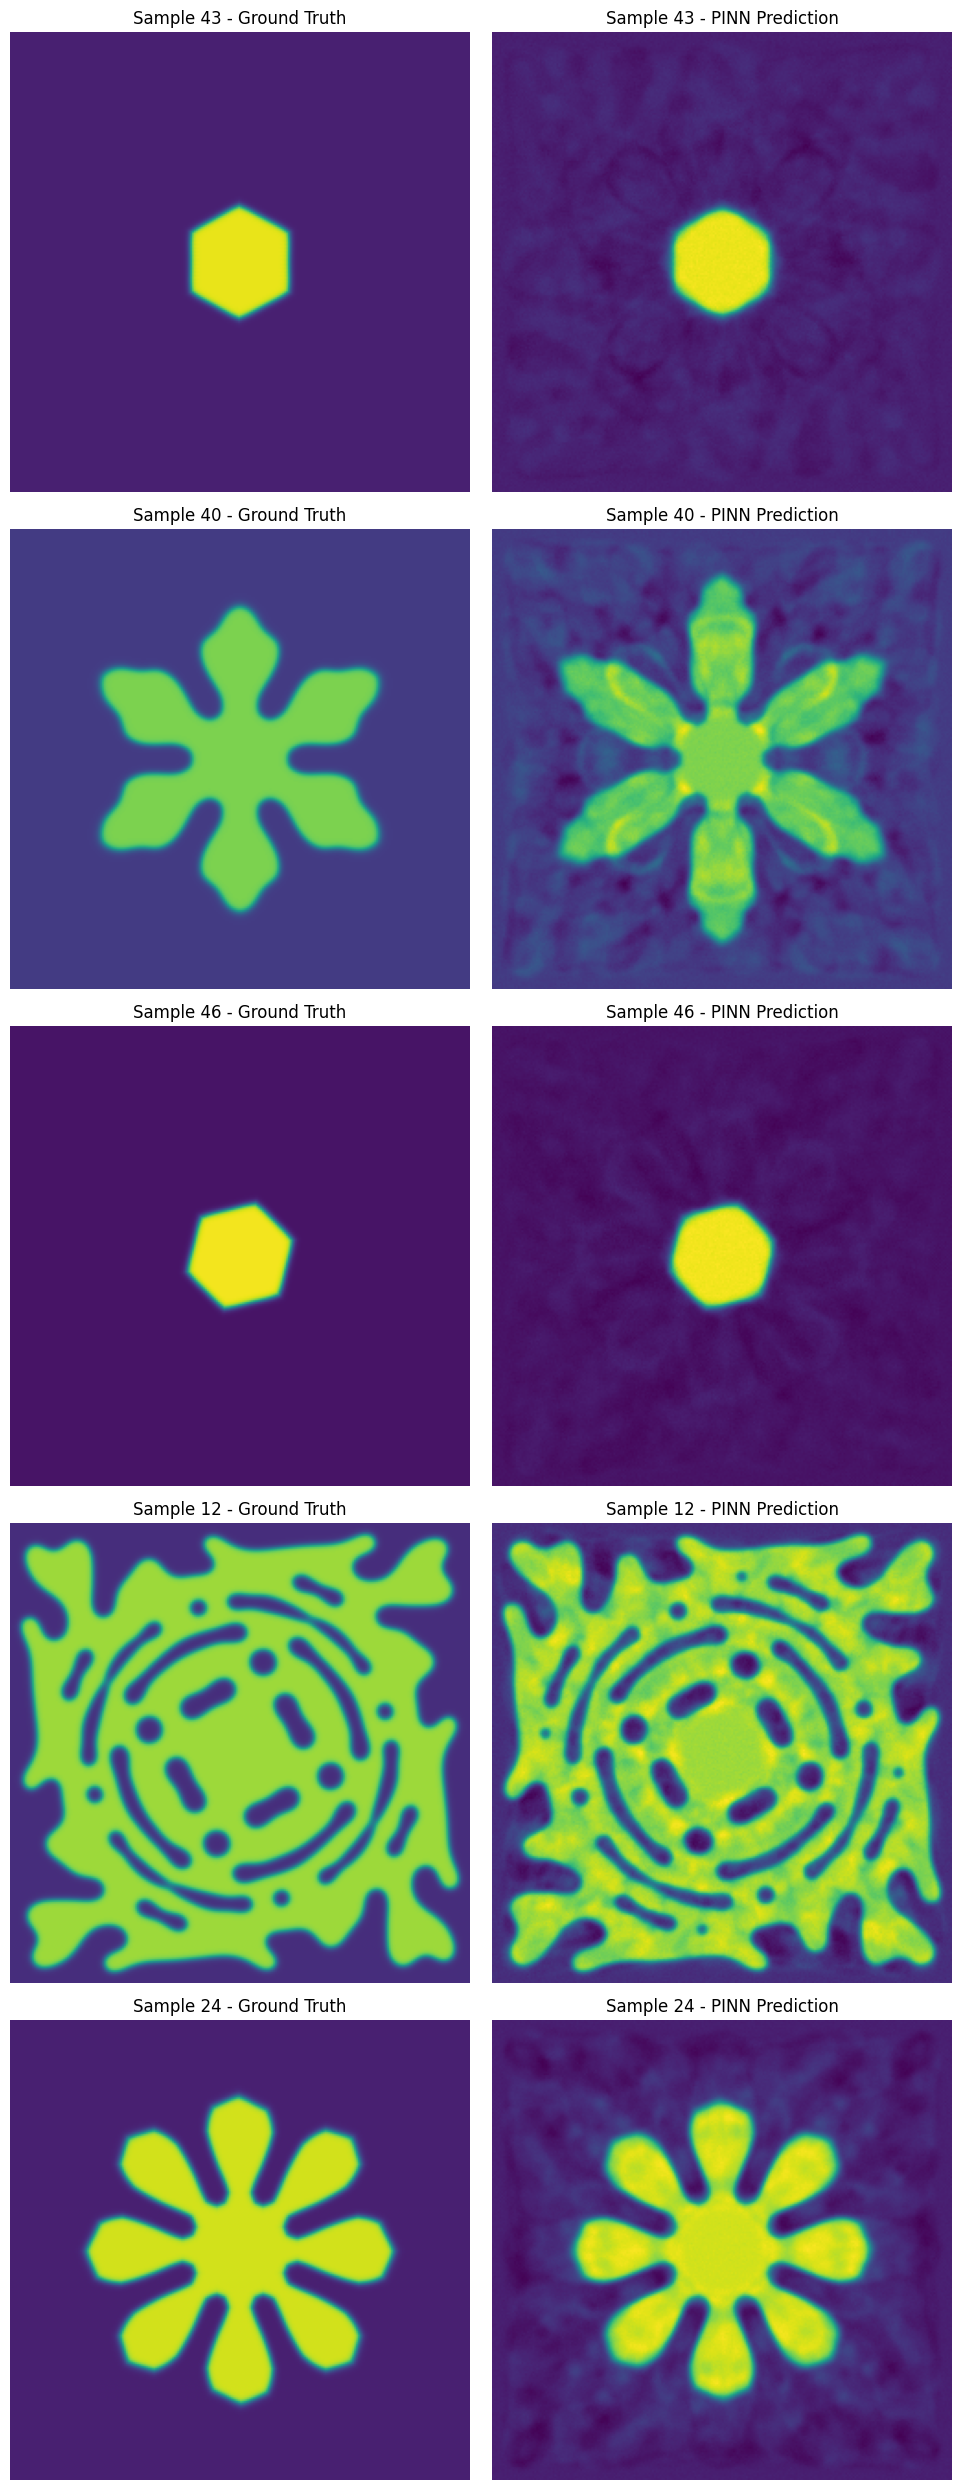

In [ ]:
# Cell 7
# plotting the predictions

def plot_multiple_comparisons(indices):
    model.eval()
    
    num_samples = len(indices)
    output_dim = Y_test_tensor.shape[1]
    grid_size = int(np.sqrt(output_dim))  # should be 250
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for idx, sample_idx in enumerate(indices):
        with torch.no_grad():
            input_sample = X_test_tensor[sample_idx:sample_idx+1]
            pred = model(input_sample).cpu().numpy().reshape(grid_size, grid_size)
            true = Y_test_tensor[sample_idx].cpu().numpy().reshape(grid_size, grid_size)

        vmin = min(pred.min(), true.min())
        vmax = max(pred.max(), true.max())

        axs[idx, 0].imshow(true, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 0].set_title(f'Sample {sample_idx} - Ground Truth')
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(pred, cmap='viridis', vmin=vmin, vmax=vmax)
        axs[idx, 1].set_title(f'Sample {sample_idx} - PINN Prediction')
        axs[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example: plot 5 random samples
np.random.seed(42)  # for reproducibility
random_indices = np.random.choice(len(X_test), size=5, replace=False)
plot_multiple_comparisons(random_indices)


Outputs are accurate.